In [18]:
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from rasterio.transform import from_origin



In [10]:

try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

### Cargamos la imagen

In [11]:
Image.MAX_IMAGE_PIXELS = None
# path  = '/content/drive/My Drive/doctorado_albert/conteo_pinguinos/'
# image_name = "orthomosaic_all_big.tif"

NUM_TILE = 62

if os.path.exists('/content/drive/My Drive/doctorado_albert/conteo_pinguinos/'):
    path  = '/content/drive/My Drive/doctorado_albert/conteo_pinguinos/'
else:
    path = 'G:\\.shortcut-targets-by-id\\1pYgV5EIk4-LapLNhlCwpQaDAzuqNffXG\\doctorado_albert\\conteo_pinguinos'

image_name = f"recortes/recorte_{NUM_TILE}.tif"

# Unir el path con el nombre de la imagen
tiff_file = os.path.join(path, image_name)

# Verificamos la carga de la imagen (este código no será necesario más tarde, ya que usaremos rasteiro)
image = Image.open(tiff_file)
print(f"Imagen cargada desde: {tiff_file}")
print("Dimensiones: ", image.size)

Imagen cargada desde: G:\.shortcut-targets-by-id\1pYgV5EIk4-LapLNhlCwpQaDAzuqNffXG\doctorado_albert\conteo_pinguinos\recortes/recorte_62.tif
Dimensiones:  (10195, 11420)


### Mostramos la información

In [12]:
with rasterio.open(tiff_file) as src:
    # Obtener los metadatos
    transform = src.transform
    metadata = src.meta
    top_left = src.transform * (0, 0)
    top_right = src.transform * (src.width, 0)
    bottom_left = src.transform * (0, src.height)
    bottom_right = src.transform * (src.width, src.height)

   
    print("Metadatos de la imagen:")
    for key, value in metadata.items():
        print(f"{key}: {value}")

    # También puedes acceder a información específica si lo deseas
    print("\nInformación adicional:")
    print("Ancho y alto de la imagen:", src.width, ' x ' , src.height)
    print("Sistema de coordenadas:", src.crs)  # Sistema de referencia de coordenadas
    print("Transformación:", src.transform)  # Transformación espacial

    print("Coordenadas de las esquinas de la imagen:")
    print("TOP LEFT:", top_left)
    print("BOTTOM RIGHT:", bottom_right)
    print("TOP RIGHT:", top_right)
    print("BOTTOM LEFT:", bottom_left)
    

Metadatos de la imagen:
driver: GTiff
dtype: uint8
nodata: None
width: 10195
height: 11420
count: 4
crs: EPSG:4326
transform: | 0.00, 0.00,-59.24|
| 0.00,-0.00,-62.30|
| 0.00, 0.00, 1.00|

Información adicional:
Ancho de la imagen: 10195
Altura de la imagen: 11420
Sistema de coordenadas: EPSG:4326
Transformación: | 0.00, 0.00,-59.24|
| 0.00,-0.00,-62.30|
| 0.00, 0.00, 1.00|


### Definimos las coordenadas del Tile

In [14]:
min_x, max_y = bottom_right
max_x, min_y = top_left

print (bottom_right, top_left)

(-59.231134009926784, -62.303714473634734) (-59.236389267356785, -62.300974267474736)



**IMAGEN 62**

Esquina superior izquierda: (-59.236389267356785, -62.300974267474736)

Esquina superior derecha: (-59.231134009926784, -62.300974267474736)

Esquina inferior izquierda: (-59.236389267356785, -62.303714473634734)

Esquina inferior derecha: (-59.231134009926784, -62.303714473634734)

---

**IMAGEN 52**

Esquina superior izquierda: (-59.236389267356785, -62.29823406131474)

Esquina superior derecha: (-59.231134009926784, -62.29823406131474)

Esquina inferior izquierda: (-59.236389267356785, -62.300974267474736)

Esquina inferior derecha: (-59.231134009926784, -62.300974267474736)

### Cargamos el csv o JSON donde están las coordenadas

In [15]:

csv_file = os.path.join(path, 'chinstraps_eca56.csv')

# Lee el archivo CSV con la codificación correcta
data = pd.read_csv(csv_file, encoding='ISO-8859-1')

data.tail()

,Id,X,Y
36806,0,-59.229433,-62.306504
36807,0,-59.229478,-62.306502
36808,0,-59.229447,-62.306497
36809,0,-59.229484,-62.306495
36810,0,-59.229446,-62.306488


### Extraemos las coordenadas que están dentro del Tile en el que estamos trabajando

Para filtrar las coordenadas en tu archivo CSV y guardar solo aquellas que están dentro del área geográfica de un tile específico, necesitas seguir los siguientes pasos:

-Definir las coordenadas del tile: Obtén las coordenadas de las esquinas del tile que estás usando, que ya has calculado anteriormente.

-Filtrar las coordenadas: Compara las coordenadas del CSV con las del tile y guarda solo aquellas que estén dentro de los límites.


In [24]:
# Filtrar los puntos que están dentro del tile
filtered_data = data[
    (data['X'] <= min_x) & (data['X'] >= max_x) &
    (data['Y'] <= min_y) & (data['Y'] >= max_y)
]
filtered_data.to_csv(os.path.join('tiles_coords', f'coords_{NUM_TILE}.csv'), index=False)
filtered_data.head()

,Id,X,Y
12767,0,-59.231135,-62.301436
12833,0,-59.231152,-62.301431
12834,0,-59.231148,-62.301438
12835,0,-59.231172,-62.301442
12836,0,-59.231155,-62.301445


### Creamos un cuadrado en torno a cada punto

In [21]:
# Inicializar una lista para almacenar los datos de los cuadrados
squares = []

# Definir el tamaño del cuadrado (15 píxeles de desplazamiento)
offset = 15

# Calcular las coordenadas de los cuadrados
for _, row in filtered_data.iterrows():
    x, y = row['X'], row['Y']

    # Convertir coordenadas geográficas a píxeles
    pixel_x, pixel_y = ~transform * (x, y)
    pixel_x, pixel_y = int(pixel_x), int(pixel_y)

    # Calcular las esquinas del cuadrado
    top_left = (pixel_x - offset, pixel_y - offset)  # Arriba izquierda
    bottom_right = (pixel_x + offset, pixel_y + offset)  # Abajo derecha

    # Agregar los datos del cuadrado a la lista
    squares.append({
        'Id': row['Id'],
        'Top_Left_X': top_left[0],
        'Top_Left_Y': top_left[1],
        'Bottom_Right_X': bottom_right[0],
        'Bottom_Right_Y': bottom_right[1]
    })

# Crear un DataFrame a partir de la lista de cuadrados
square_data = pd.DataFrame(squares)

# Mostrar el nuevo DataFrame
print(square_data.head())

    Id  Top_Left_X  Top_Left_Y  Bottom_Right_X  Bottom_Right_Y
0  0.0       10178        1909           10208            1939
1  0.0       10145        1889           10175            1919
2  0.0       10153        1918           10183            1948
3  0.0       10105        1935           10135            1965
4  0.0       10139        1946           10169            1976


### Pintamos un cuadrado en torno a square_data
---



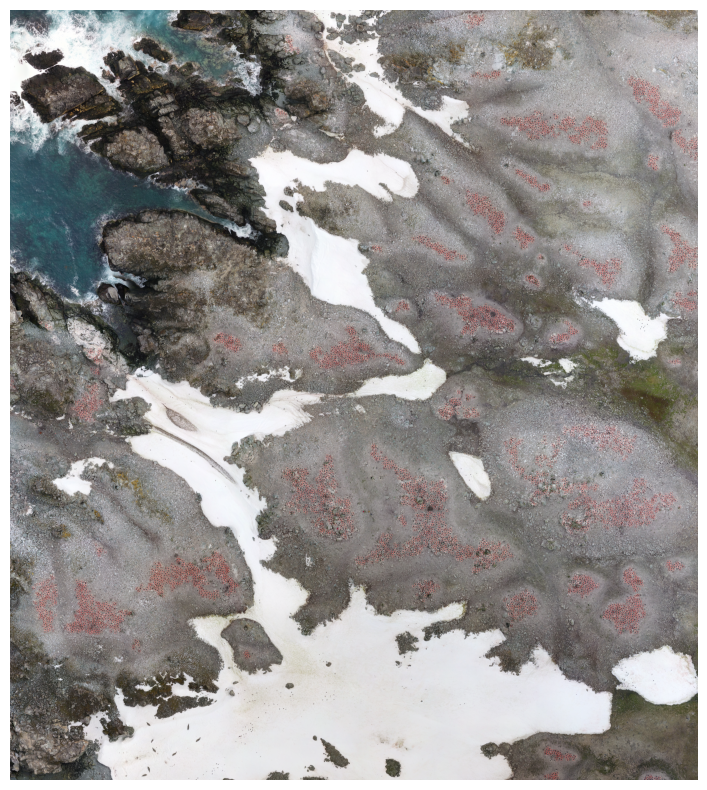

In [22]:
# Abre el archivo TIFF
with rasterio.open(tiff_file) as src:
    # Leer la imagen y obtener la transformación
    image = src.read()
    transform = src.transform

# Crear una copia de la imagen para modificarla
image_with_squares = image.copy()

# Pintar los bordes de los cuadrados en rojo
for _, row in square_data.iterrows():
    top_left_x = row['Top_Left_X']
    top_left_y = row['Top_Left_Y']
    bottom_right_x = row['Bottom_Right_X']
    bottom_right_y = row['Bottom_Right_Y']

    # Asegurarse de que las coordenadas estén dentro de los límites de la imagen
    top_left_x, top_left_y = int(top_left_x), int(top_left_y)
    bottom_right_x, bottom_right_y = int(bottom_right_x), int(bottom_right_y)

    if 0 <= top_left_x < image.shape[2] and 0 <= top_left_y < image.shape[1] and \
       0 <= bottom_right_x < image.shape[2] and 0 <= bottom_right_y < image.shape[1]:

        # Pintar los bordes en rojo (delimitados por píxeles)
        # Borde superior
        for x in range(top_left_x, bottom_right_x):
            image_with_squares[0, top_left_y, x] = 255  # R
            image_with_squares[1, top_left_y, x] = 0    # G
            image_with_squares[2, top_left_y, x] = 0    # B

        # Borde inferior
        for x in range(top_left_x, bottom_right_x):
            image_with_squares[0, bottom_right_y - 1, x] = 255  # R
            image_with_squares[1, bottom_right_y - 1, x] = 0    # G
            image_with_squares[2, bottom_right_y - 1, x] = 0    # B

        # Borde izquierdo
        for y in range(top_left_y, bottom_right_y):
            image_with_squares[0, y, top_left_x] = 255  # R
            image_with_squares[1, y, top_left_x] = 0    # G
            image_with_squares[2, y, top_left_x] = 0    # B

        # Borde derecho
        for y in range(top_left_y, bottom_right_y):
            image_with_squares[0, y, bottom_right_x - 1] = 255  # R
            image_with_squares[1, y, bottom_right_x - 1] = 0    # G
            image_with_squares[2, y, bottom_right_x - 1] = 0    # B

# Mostrar la imagen resultante
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(image_with_squares, (1, 2, 0)))  # Cambiar el orden para mostrar correctamente
plt.axis('off')  # Quitar los ejes
plt.show()


In [23]:
# Guardar la imagen modificada en el directorio especificado
output_image_path = os.path.join('square_maps', f'map_with_square_tile_{NUM_TILE}.tif')

# Guardar la imagen modificada en el directorio especificado
with rasterio.open(output_image_path, 'w', driver='GTiff', height=image_with_squares.shape[1],
                   width=image_with_squares.shape[2], count=image_with_squares.shape[0],
                   dtype=image_with_squares.dtype, crs=src.crs, transform=src.transform) as dst:
    dst.write(image_with_squares)

print(f"La imagen modificada se ha guardado como {output_image_path}")

La imagen modificada se ha guardado como square_maps\map_with_square_tile_62.tif
